In [28]:
import numpy as np
import json
from PIL import Image, ImageDraw
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [29]:
train_image_dir = "../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen"

image_paths_train = []

for i in os.listdir(train_image_dir):
    folder_path = os.path.join(train_image_dir, i)
    if i != '.DS_Store':
        image_paths_train.append(folder_path)

In [30]:
train_label_dir = "../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen"

label_paths_train = []

for i in os.listdir(train_label_dir):
    folder_path = os.path.join(train_label_dir, i)
    if i != '.DS_Store':
        label_paths_train.append(folder_path)

In [31]:
df_image_paths_train = pd.DataFrame({"Index": "", "Image_Path": image_paths_train})
df_label_paths_train = pd.DataFrame({"Index": "", "Target_Path": label_paths_train})

In [32]:
filter_instanceIds = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('instanceIds')]
filter_color = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('color')]
filter_labelIds = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('labelIds')]

df_label_paths_train = df_label_paths_train.drop(filter_instanceIds.index)
df_label_paths_train = df_label_paths_train.drop(filter_color.index)
df_label_paths_train = df_label_paths_train.drop(filter_labelIds.index)

In [33]:
index_tab = []
for el in df_image_paths_train['Image_Path']:
    file_name = os.path.splitext(os.path.basename(el))[0]
    file_name = file_name.replace("_leftImg8bit", "")
    index_tab.append(file_name)
df_image_paths_train['Index'] = index_tab

In [34]:
index_tab = []
for el in df_label_paths_train['Target_Path']:
    file_name = os.path.splitext(os.path.basename(el))[0]
    file_name = file_name.replace("_gtFine_polygons", "")
    index_tab.append(file_name)
df_label_paths_train['Index'] = index_tab

In [35]:
df_train = pd.merge(df_image_paths_train, df_label_paths_train, on='Index', how='left')
df_train

,Index,Image_Path,Target_Path
0,aachen_000079_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000079_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000079_000019_gtFine_polygons.json
1,aachen_000073_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000073_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000073_000019_gtFine_polygons.json
2,aachen_000100_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000100_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000100_000019_gtFine_polygons.json
3,aachen_000006_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000006_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000006_000019_gtFine_polygons.json
4,aachen_000037_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000037_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000037_000019_gtFine_polygons.json
...,...,...,...
169,aachen_000025_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000025_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000025_000019_gtFine_polygons.json
170,aachen_000156_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000156_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000156_000019_gtFine_polygons.json
171,aachen_000091_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000091_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000091_000019_gtFine_polygons.json
172,aachen_000050_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000050_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000050_000019_gtFine_polygons.json


In [36]:
for file_target in df_train['Target_Path']:
    with open(file_target, 'r') as f:
        data = json.load(f)
    
    polygon_tab = []
    for ob in data['objects']:
        if ob['label'] == 'car':
            polygon_tab.append(ob['polygon'])
    
    mask = np.zeros((data['imgHeight'], data['imgWidth'], 2), dtype=np.uint8)
    mask_image = Image.new("L", (data['imgWidth'], data['imgHeight']), 0)

    for masks in polygon_tab:
        mask_tab = []
        for x, y in masks:
            mask_tab.append((x, y))
        ImageDraw.Draw(mask_image).polygon(mask_tab, outline=1, fill=255)

    mask = np.array(mask_image)
    file_npy = os.path.splitext(os.path.basename(file_target))[0]
    file_npy = file_npy.replace("_gtFine_polygons", "")
    np.save(f"./data/{file_npy}.npy", mask)

In [37]:
npy_mask = "./data/"
npy_tab = []

for i in os.listdir(npy_mask):
    npy_file_list = os.path.splitext(os.path.basename(i))[0]
    npy_tab.append({"Index": npy_file_list, "NPY_Path": i})

npy_tab = pd.DataFrame(npy_tab)
df_train = pd.merge(df_train, npy_tab, on='Index', how='left')
df_train

,Index,Image_Path,Target_Path,NPY_Path
0,aachen_000079_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000079_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000079_000019_gtFine_polygons.json,aachen_000079_000019.npy
1,aachen_000073_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000073_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000073_000019_gtFine_polygons.json,aachen_000073_000019.npy
2,aachen_000100_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000100_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000100_000019_gtFine_polygons.json,aachen_000100_000019.npy
3,aachen_000006_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000006_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000006_000019_gtFine_polygons.json,aachen_000006_000019.npy
4,aachen_000037_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000037_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000037_000019_gtFine_polygons.json,aachen_000037_000019.npy
...,...,...,...,...
169,aachen_000025_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000025_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000025_000019_gtFine_polygons.json,aachen_000025_000019.npy
170,aachen_000156_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000156_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000156_000019_gtFine_polygons.json,aachen_000156_000019.npy
171,aachen_000091_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000091_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000091_000019_gtFine_polygons.json,aachen_000091_000019.npy
172,aachen_000050_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000050_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000050_000019_gtFine_polygons.json,aachen_000050_000019.npy


In [41]:
test1 = np.load('./data/' + df_train['NPY_Path'][10])

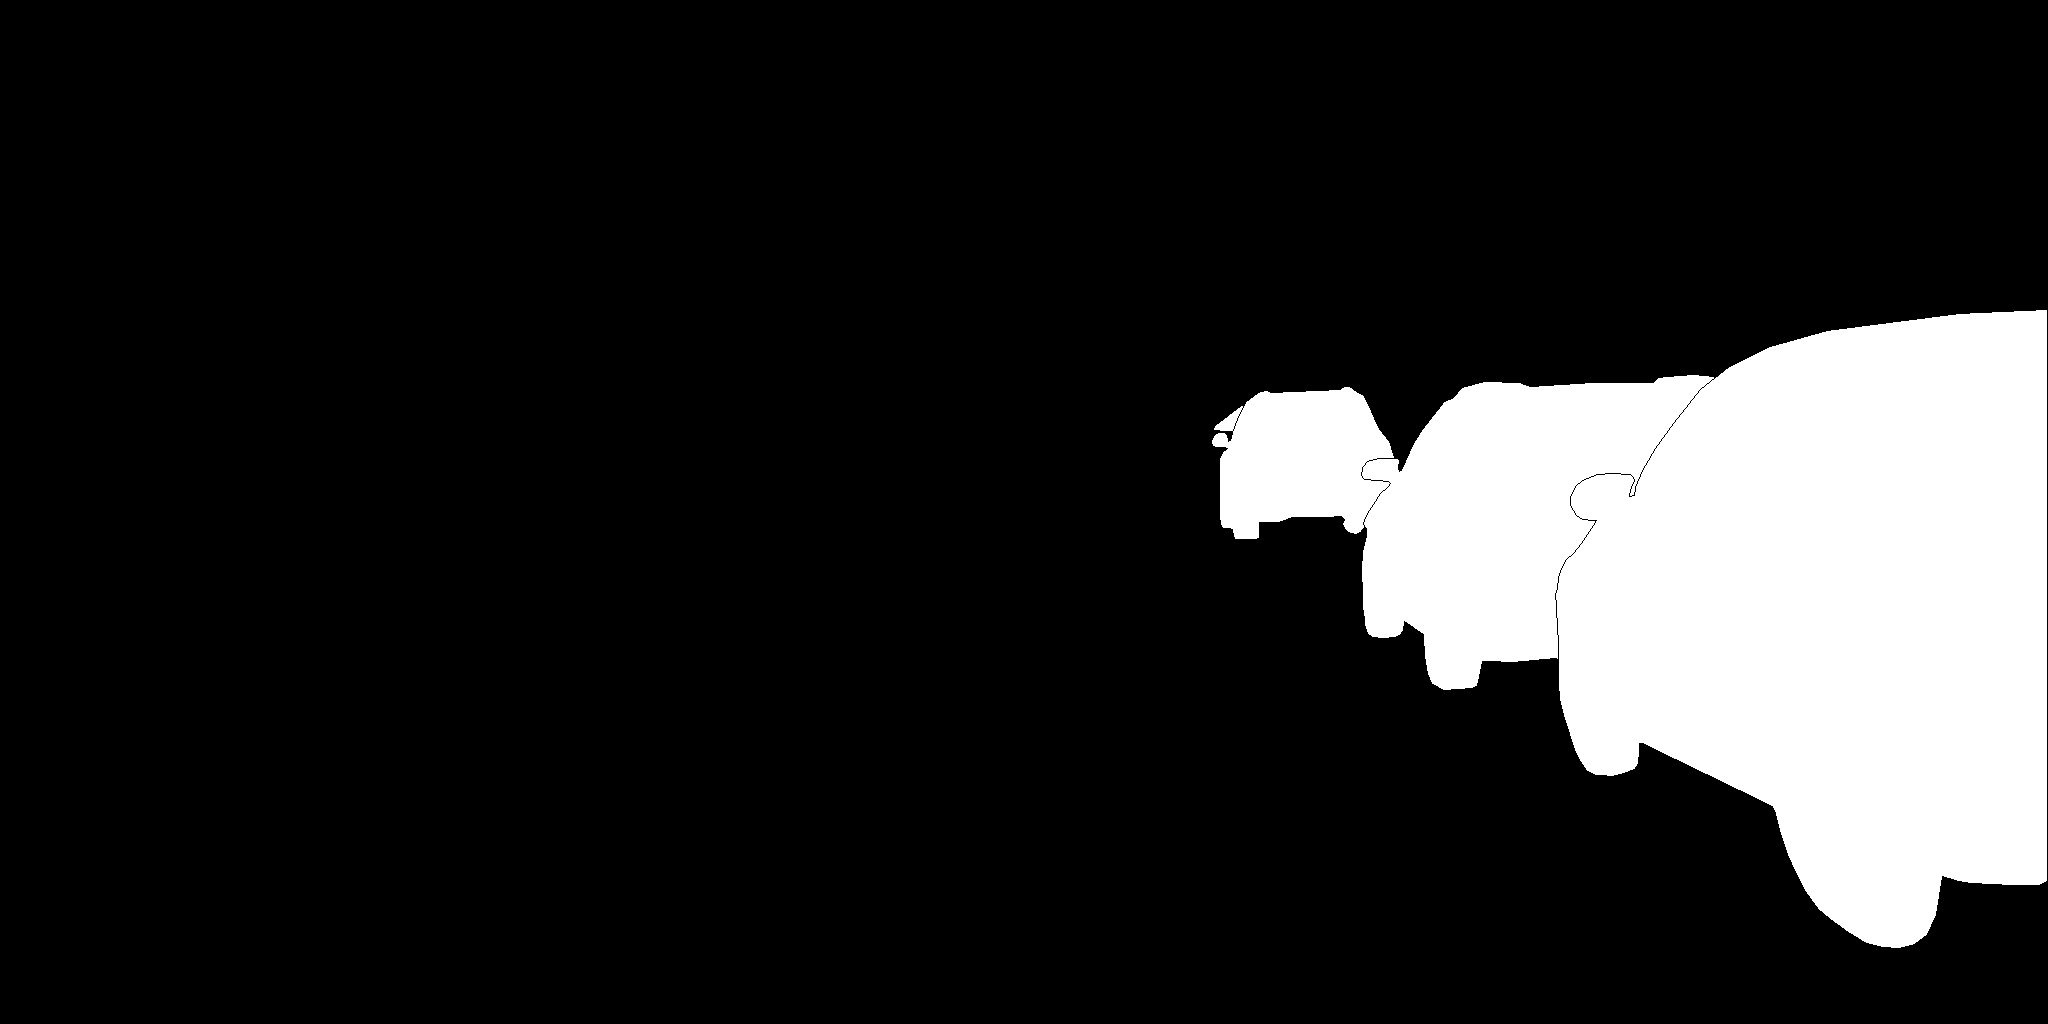

In [42]:
test1_Img = Image.fromarray(test1)
test1_Img

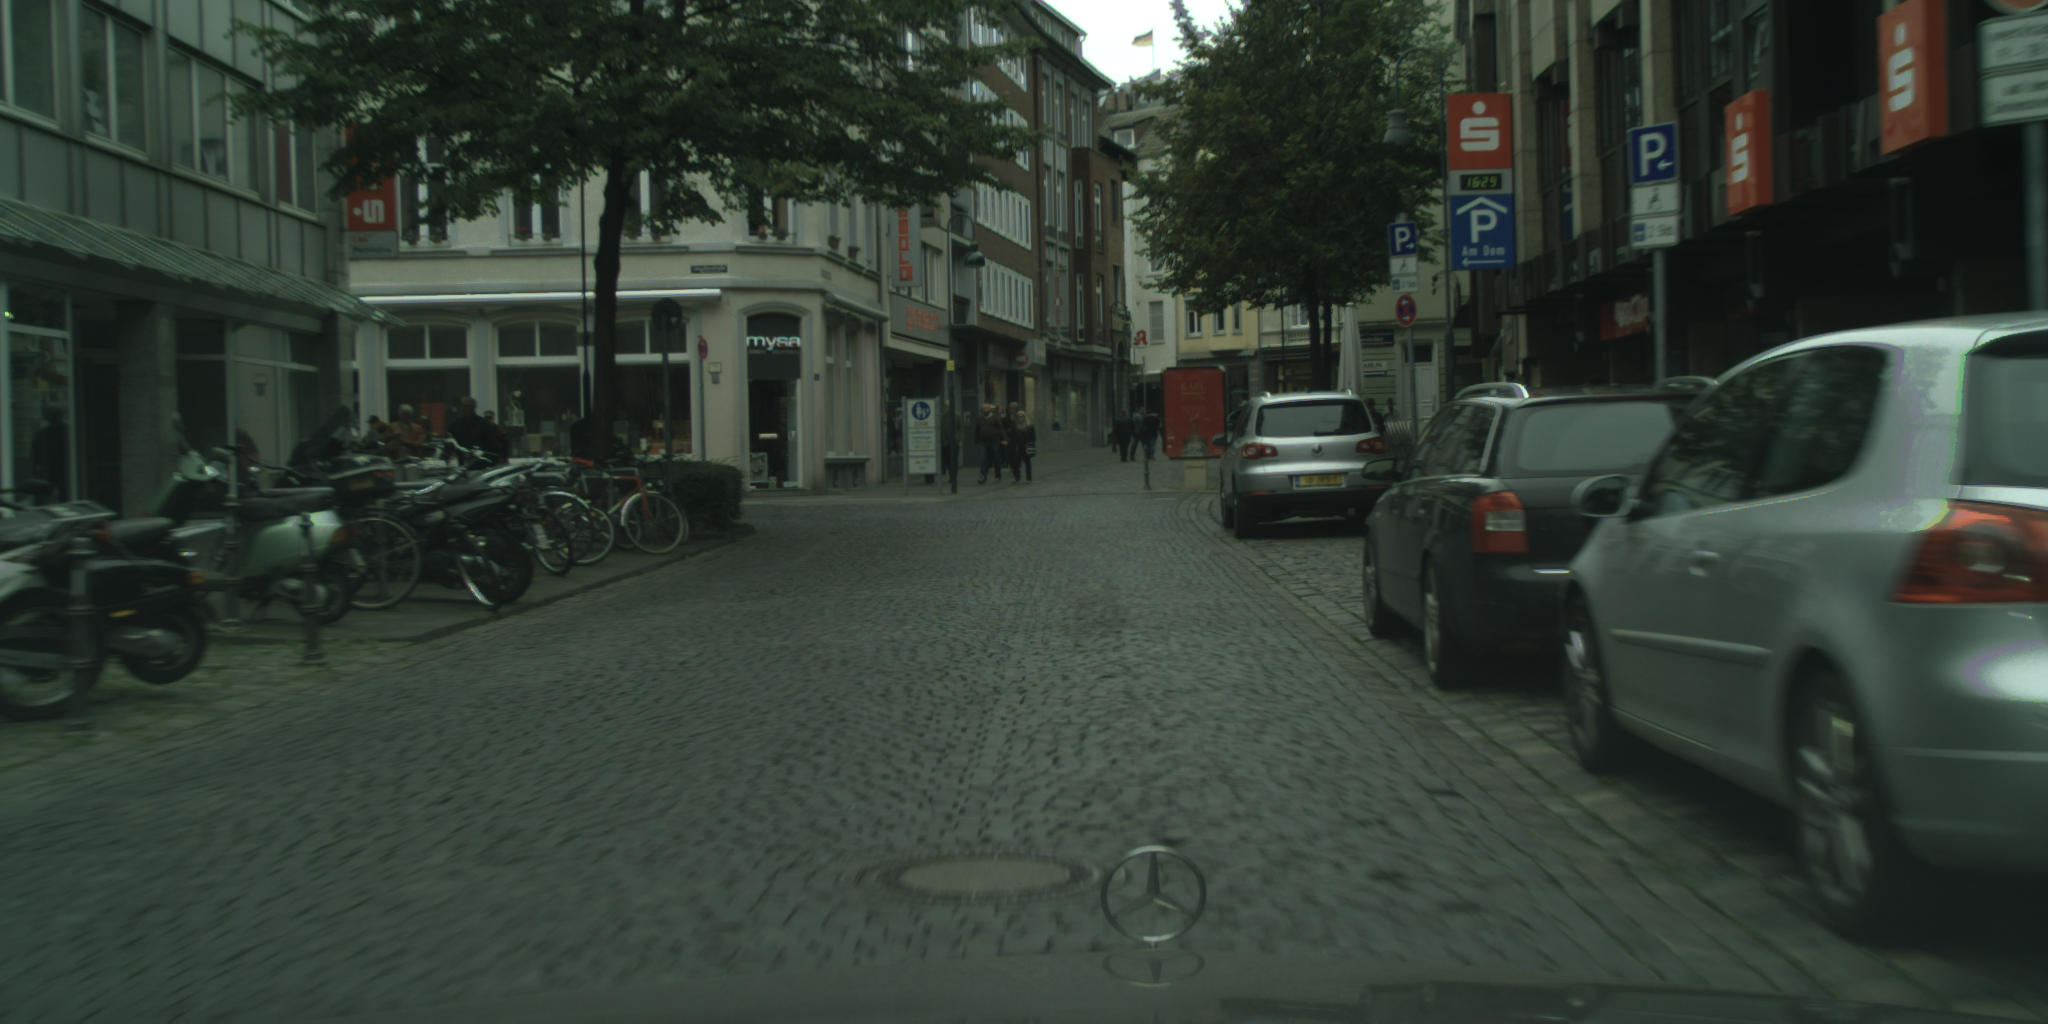

In [43]:
Image.open(df_train['Image_Path'][10])